In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load preprocessed data
data = pd.read_csv('../data/bugs_preprocessed.csv')

In [3]:
# I will use the only text as feature
#X = data['text_processed']
#y = data['severity_category']

In [4]:
# Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print(f"Development set: {len(X_train)} samples")
print(f"Test set (holdout): {len(X_test)} samples")

Development set: 7998 samples
Test set (holdout): 2000 samples


In [5]:
# TF-IDF with 1000 words and accept terms that have document frequency between 2 and 80% of total documents
tfidf = TfidfVectorizer(max_features = 1000, min_df = 2, max_df = 0.8)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.fit_transform(X_test)

print(f"TF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

TF-IDF matrix shape (train): (7998, 1000)
TF-IDF matrix shape (test): (2000, 1000)
Number of features: 1000


In [6]:
# Define Stratified K-Fold strategy, since the class distribution are not even
# with more than 70% data is in Normal category
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [7]:
# Compare different models using cross-validation
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

In [8]:
# Cross-Validation process and pick the best model name
best_model_name = None
best_score = 0

for model_name, model in models.items():
    # Cross-Validation scores
    cv_scores = cross_val_score(
        model, X_train_tfidf, y_train, 
        cv=cv, 
        scoring='f1_weighted',  # Better for imbalanced classes
        n_jobs=-1
    )
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()

    print(f"\n{model_name}:")
    print(f"  F1-Score: {mean_score:.4f} (±{std_score:.4f})")
    print(f"  All folds: {cv_scores}")

    if mean_score > best_score:
        best_score = mean_score
        best_model_name = model_name
print(f"\nBest model from CV: {best_model_name} (F1={best_score:.4f})")


Naive Bayes:
  F1-Score: 0.6708 (±0.0015)
  All folds: [0.67005194 0.66871917 0.67042547 0.67236027 0.67264429]

Logistic Regression:
  F1-Score: 0.6938 (±0.0039)
  All folds: [0.68894662 0.69862585 0.69410518 0.69001978 0.69743276]

Random Forest:
  F1-Score: 0.6969 (±0.0061)
  All folds: [0.69292988 0.6912452  0.70281665 0.69192947 0.70562403]

Best model from CV: Random Forest (F1=0.6969)


In [9]:
# Train best model
best_model = models[best_model_name]
best_model.fit(X_train_tfidf, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
# Final evaluation with holdout test set
# Since the X_test has been transformed before, I am predicting it
y_pred = best_model.predict(X_test_tfidf)

In [11]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

     blocker       0.00      0.00      0.00        41
    critical       0.10      0.01      0.02       121
       major       0.00      0.00      0.00       148
       minor       0.00      0.00      0.00       108
      normal       0.76      0.99      0.86      1521
     trivial       0.00      0.00      0.00        61

    accuracy                           0.75      2000
   macro avg       0.14      0.17      0.15      2000
weighted avg       0.58      0.75      0.65      2000



D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\Project\Nisa Python\hihihi\bug-priority-predictor\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

In [12]:
# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Confusion Matrix:
[[   0    0    0    0   41    0]
 [   0    1    0    1  119    0]
 [   0    0    0    1  146    1]
 [   0    0    1    0  107    0]
 [   0    9    2    2 1500    8]
 [   0    0    0    0   61    0]]


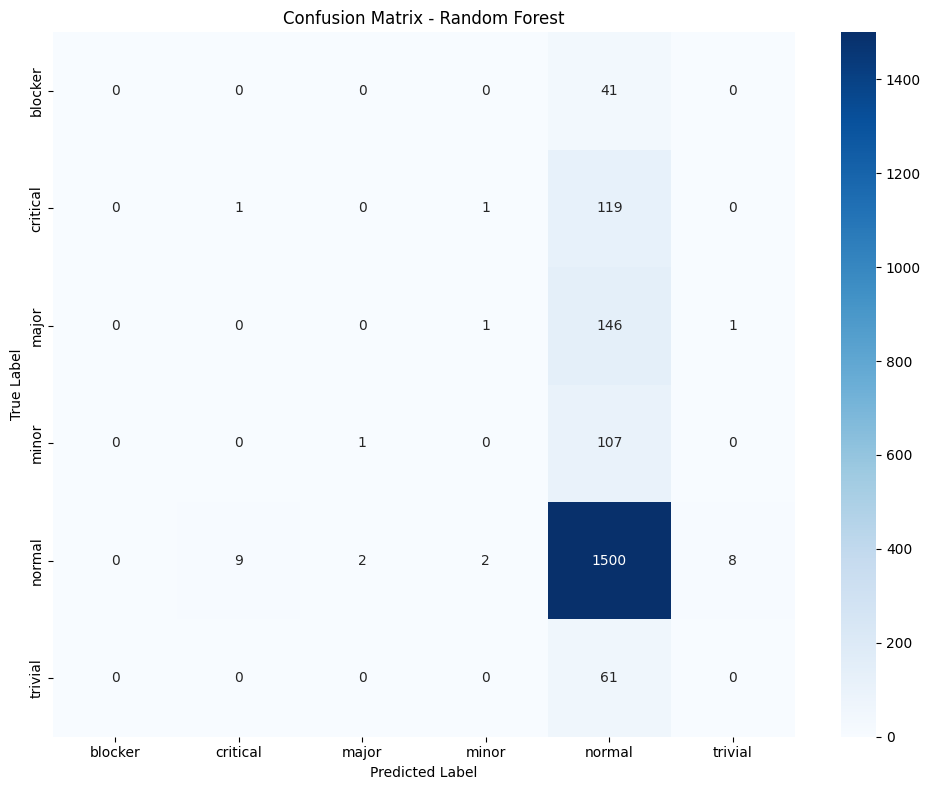

In [16]:
plt.figure(figsize=(10, 8))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=sorted(y.unique()),
           yticklabels=sorted(y.unique()))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Since the result in the confusion matrix is so bad, I'll use another approach
# Add some categorical data as input and data resampling for imbalanced data with SMOTE
data['text_length'] = data['text_processed'].str.split()

X_text = data['text_processed']
X_cat = data[['component_name', 'product_name', 'text_length']]
y = data['severity_category']

print(f"\nData shape: {data.shape}")
print("\nClass distribution:")
print(y.value_counts())